In [17]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

logdir = Path("/bigdata/f_mnist/logs/decomposed")

In [18]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 184


In [11]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2022-02-15 14:45:43
2022-02-14 18:55:24


In [9]:
# after = datetime(2022,2,14,19,0,0,0)
# before = datetime(2022,2,15,8,0,0,0)
# timestamps = []
# for ts, dt in ts_dts:
#     if dt > after and dt < before:
#         timestamps.append(ts)

In [12]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

184


In [13]:
# baseline

baseline_path = Path("/bigdata/f_mnist/logs/baselines/1644852900/rn18_18_dNone_256_sgd_l0.1_g0.1_sTrue/cnn_best.pth")
baseline_model = torch.load(baseline_path)

In [15]:
def paths_to_results(paths):
    """Returns a pandas DataFrame with results"""
    results = []
    for path in paths:
        with open(path/'results.json') as json_file:
            result = json.load(json_file)
        results.append(result)
    
    keys = set()
    for result in results:
        keys = keys.union( set(result.keys()) )
    
    blank = {k:[] for k in keys}
    
    df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

    for result in results:
        df = df.append(result, ignore_index=True)
        
    df['compression'] = df['n_param_fact']/df['n_param'][0]
    df.compression[0] = 1.0
    
    
    return df

In [16]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [19]:
original_baseline_path = "/bigdata/f_mnist/logs/1644852900/rn18_18_dNone_256_sgd_l0.1_g0.1_sTrue/cnn_best.pth"
b = True
for path in paths:
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    config_baseline_path = config_data['baseline_path']
    if b:
        print(config_baseline_path)
        print(original_baseline_path)
        print(10*"=")
        b = False
    if config_baseline_path != original_baseline_path:
        print(config_baseline_path)
        print(original_baseline_path)
        print(10*"=")

/bigdata/f_mnist/logs/1644852900/rn18_18_dNone_256_sgd_l0.1_g0.1_sTrue/cnn_best.pth
/bigdata/f_mnist/logs/1644852900/rn18_18_dNone_256_sgd_l0.1_g0.1_sTrue/cnn_best.pth


In [23]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'model_after_fact.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

In [24]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

{'name': ['conv1'], 'nr': [60], 'error': [0.49314284324645996], 'layers': [60], 'factorization': 'tucker', 'rank': 0.5, 'valid_acc': 0.9572, 'valid_acc_before_ft': 0.9568, 'n_param_fact': 9995872, 'test_acc': 0.9425, 'lr': 0.001, 'optimizer': 'sgd'}
{'name': ['conv1'], 'nr': [28], 'error': [0.3576757609844208], 'layers': [28], 'factorization': 'tucker', 'rank': '0.75', 'valid_acc': 0.957, 'valid_acc_before_ft': 0.9556, 'n_param_fact': 11136896, 'test_acc': 0.942, 'lr': 0.001, 'optimizer': 'sgd'}
{'name': ['conv2'], 'nr': [15], 'error': [0.4276449978351593], 'layers': [15], 'factorization': 'tucker', 'rank': 0.5, 'valid_acc': 0.9572, 'valid_acc_before_ft': 0.9564, 'n_param_fact': 11154645, 'test_acc': 0.9425, 'lr': 0.001, 'optimizer': 'sgd'}
{'name': ['0'], 'nr': [41], 'error': [0.6242979168891907], 'layers': [41], 'factorization': 'tucker', 'rank': 0.5, 'valid_acc': 0.9566, 'valid_acc_before_ft': 0.956, 'n_param_fact': 11156556, 'test_acc': 0.9417, 'lr': 0.001, 'optimizer': 'sgd'}
{'na

In [91]:
df = pd.DataFrame(results)


In [92]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()

array([0.5 , 0.75, 0.9 , 0.25, 0.1 ])

In [93]:
df.set_index('rank', inplace=True)

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

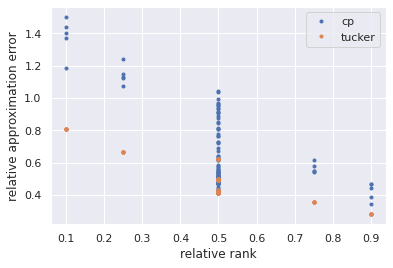

In [94]:
grouped_df = df.groupby('factorization')
grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error', xlabel='relative rank')

In [52]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


<AxesSubplot:xlabel='rank', ylabel='error'>

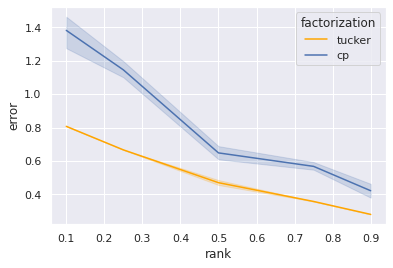

In [119]:
df = pd.DataFrame(results)
df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

In [125]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc, dtype: object

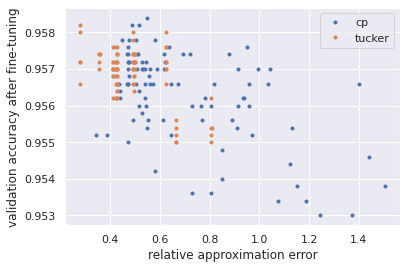

In [89]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

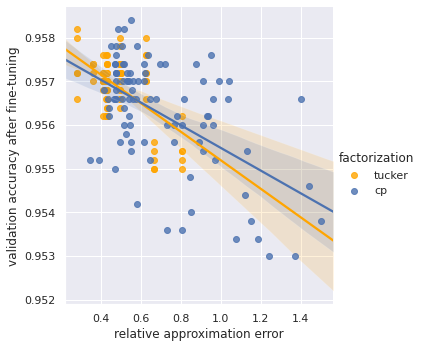

In [99]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

In [104]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank
0,conv1,60,0.493143,60,tucker,0.50,0.9572,0.9568,9995872,0.9425,0.001,sgd,tucker-0.5
1,conv1,28,0.357676,28,tucker,0.75,0.9570,0.9556,11136896,0.9420,0.001,sgd,tucker-0.75
2,conv2,15,0.427645,15,tucker,0.50,0.9572,0.9564,11154645,0.9425,0.001,sgd,tucker-0.5
3,0,41,0.624298,41,tucker,0.50,0.9566,0.9560,11156556,0.9417,0.001,sgd,tucker-0.5
4,conv1,44,0.728749,44,cp,0.50,0.9560,0.9558,10878297,0.9432,0.001,sgd,cp-0.5


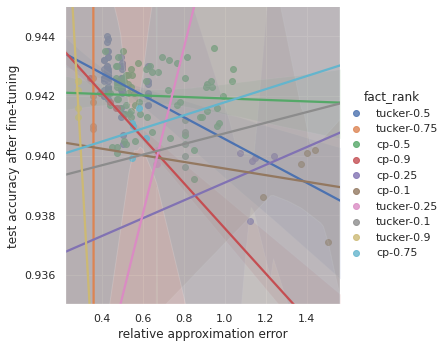

In [118]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="fact_rank", 
   data=df,
   truncate=False, 
   # palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
g.set(ylim=(0.935, 0.945))

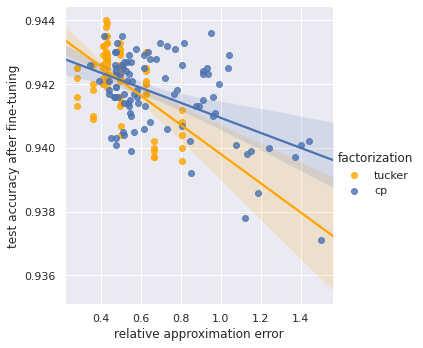

In [108]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   truncate=False, 
   palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc_before_ft, dtype: object

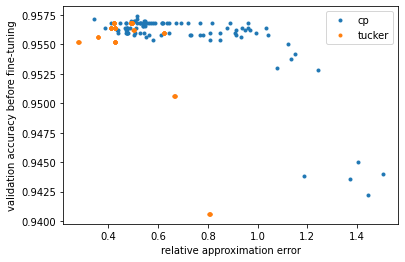

In [40]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

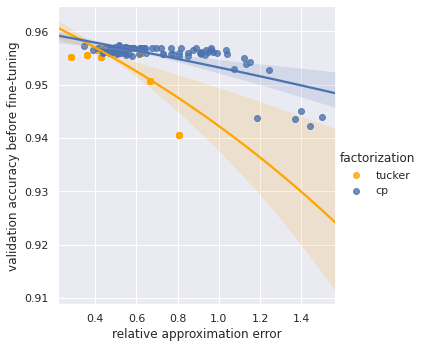

In [86]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [45]:
results_layers = []
for path in paths:
    with open( path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    # print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results_layers.append(result)

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

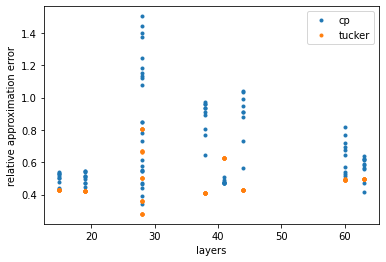

In [47]:
df_layers = pd.DataFrame(results_layers)
df_layers.set_index('layers', inplace=True)
grouped_df_layers = df_layers.groupby('factorization')
grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc, dtype: object

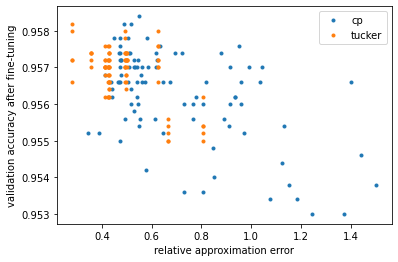

In [48]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

df_layers = pd.DataFrame(results_layers)
df_layers.set_index('error', inplace=True)
grouped_df = df_layers.groupby('factorization')
grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc_before_ft, dtype: object

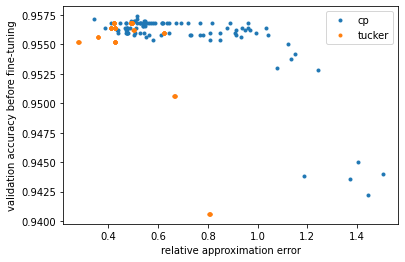

In [49]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

<AxesSubplot:xlabel='layers', ylabel='error'>

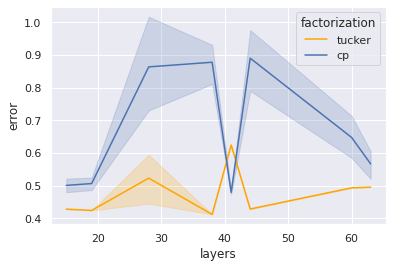

In [96]:
df = pd.DataFrame(results)
df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df,
             palette=['orange', 'b'],
             )